# 2D Incompressible Navier-Stokes Equations

\begin{align*}
\frac{\partial u}{\partial t} + \frac{\partial uu}{\partial x} + \frac{\partial vu}{\partial y} &= -\frac{1}{\rho}\frac{\partial p}{\partial x} + \frac{\mu}{\rho}\nabla ^2 u
\end{align*}

\begin{align*}
\frac{\partial v}{\partial t} + \frac{\partial uv}{\partial x} + \frac{\partial vv}{\partial y} &= -\frac{1}{\rho}\frac{\partial p}{\partial y} + \frac{\mu}{\rho} \nabla ^2 v
\end{align*}

\begin{align*}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} &= 0
\end{align*}

x-momentum discretisation
\begin{align*}
\frac{\partial u}{\partial t} &= \frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} 
\end{align*}

\begin{align*}
\left. \frac{\partial uu}{\partial x} \right |_{i,j}^n &= \frac{(uu)_{i+1, j} ^ n - (uu)_{i-1, j}^n}{2 \Delta x}
\end{align*}

\begin{align*}
\left. \frac{\partial vu}{\partial y} \right |_{i,j} ^ n &= \frac{(vu)_{i, j+1}^n - (vu)_{i, j-1}^n}{2 \Delta y}
\end{align*}

\begin{align*}
\left. \nabla ^2 u \right |_{i,j}^n &= \frac{u_{i-1,j}^n - 2u_{i,j}^n + u_{i+1, j}^n}{\Delta x^2} + \frac{u_{i,j-1}^n - 2u_{i,j}^n + u_{i, j+1}^n}{\Delta y^2}
\end{align*}

\begin{align*}
\left. \frac{\partial p}{\partial x} \right |_{i,j} &= \frac{p_{i+1, j} - p_{i-1, j}}{2 \Delta x}
\end{align*}

y-momentum discretisation
\begin{align*}
\frac{\partial v}{\partial t} &= \frac{v_{i,j}^{n+1} - v_{i,j}^n}{\Delta t} 
\end{align*}

\begin{align*}
\left. \frac{\partial uv}{\partial x} \right |_{i,j}^n &= \frac{(uv)_{i+1, j} ^ n - (uv)_{i-1, j}^n}{2 \Delta x}
\end{align*}

\begin{align*}
\left. \frac{\partial vv}{\partial y} \right |_{i,j} ^ n &= \frac{(vv)_{i, j+1}^n - (vv)_{i, j-1}^n}{2 \Delta y}
\end{align*}

\begin{align*}
\left. \nabla ^2 v \right |_{i,j}^n &= \frac{v_{i-1,j}^n - 2v_{i,j}^n + v_{i+1, j}^n}{\Delta x^2} + \frac{v_{i,j-1}^n - 2v_{i,j}^n + v_{i, j+1}^n}{\Delta y^2}
\end{align*}

\begin{align*}
\left. \frac{\partial p}{\partial y} \right |_{i,j} &= \frac{p_{i,j+1} - p_{i,j-1}}{2 \Delta y}
\end{align*}

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

plt.rcParams['animation.html'] = 'html5'

In [2]:
def ddx(f, dx):
    result = np.zeros_like(f) 
    result[1:-1, 1:-1] = (f[1:-1, 2:] - f[1:-1, :-2])/2.0/dx
    return result 

def ddy(f, dy):
    result = np.zeros_like(f)
    result[1:-1, 1:-1] = (f[2:, 1:-1] - f[:-2, 1:-1])/2.0/dy 
    return result


def laplacian(f, dx, dy):
    result = np.zeros_like(f) 
    result[1:-1, 1:-1] = (f[1:-1, 2:] - 2*f[1:-1, 1:-1] + f[1:-1, :-2])/dx/dx + (f[2:, 1:-1] - 2*f[1:-1, 1:-1] + f[:-2, 1:-1])/dy/dy 
    return result


def div(u, v, dx, dy):
    return ddx(u, dx) + ddy(v, dy)

def poisson(p, dx, dy, rhs):
    tol = 1e-5
    error = 100 
    max_it = 100 
    it = 0 
    beta = 1.0 

    while error > tol and it < max_it:
        # Neumann boundary conditions 
        p[-1, :] = 0.0          # top wall
        p[0, :] = p[1, :]       # bottom wall
        p[:, -1] = p[:, -2]     # right wall 
        p[:, 0] = p[:, 1]       # left wall 
        
        p_k = p.copy() 

        for i in range(1, nx-1):
            for j in range(1, ny-1):
                p[j, i] = beta*1.0/2.0/(dx*dx + dy*dy) * (-(dx*dx*dy*dy)*rhs[j, i]  + dy*dy*(p[j,i+1] + p[j, i-1]) + dx*dx*(p[j+1, i] + p[j-1, i])) + (1.0 - beta)*p_k[j, i]


        diff = p - p_k 
        error = np.linalg.norm(diff, 2)
        it += 1
    return error

In [20]:
def poisson_vectorised(p, dx, dy, b):
    pn = np.empty_like(p) 
    pn = p.copy() 
    it = 0 
    err = 1e5 
    tol = 1e-3 
    maxit = 25 
    while it < maxit and err > tol:
        pn = p.copy() 
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) / 
                          (2 * (dx**2 + dy**2)) - 
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) *
                          b[1:-1, 1:-1])
    
        p[:, -1] = p[:, -2] # dp/dy = 0 at x = 2 
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0 
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0 
        p[-1, :] = 0        # p = 0 at the top wall 
        err = np.linalg.norm(p.ravel() - pn.ravel(), 2)
        it += 1 

    return err 

In [30]:
Lx = 1.0    # m 
Ly = 1.0    # m

nx = 32 
ny = 32

x = np.linspace(0, Lx, nx) 
dx = x[1] - x[0]

y = np.linspace(0, Ly, ny) 
dy = y[1] - y[0] 

xx, yy = np.meshgrid(x, y)

# conditions and flow properties 
Uwall = 1.0     # m/s - top wall velocity
nu = 0.05       # m2/s - kinematic viscosity

# stability conditions 
dt1 = 0.5/(nu*(1.0/dx/dx + 1.0/dy/dy))
dt2 = 2.0*nu/(Uwall*Uwall) 
dt = min(dt1, dt2)

u = np.zeros([ny, nx]) 
v = np.zeros_like(u) 
p = np.zeros_like(u) 

t = 0.0 
tend = 100*dt 

while t < tend: 
   # set boundary conditions 
   # top wall
   u[-1, :] = Uwall 
   v[-1, :] = 0.0 
   # bottom wall 
   u[0, :] = 0.0
   v[0, :] = 0.0
   # right wall 
   u[:, -1] = 0.0 
   v[:, -1] = 0.0 
   # left wall 
   u[:, 0] = 0.0
   v[:, 0] = 0.0 

   # x-momentum 
   uRHS = -ddx(u*u, dx) - ddy(v*u, dy) + nu*laplacian(u, dx, dy)
   # v-momentum
   vRHS = - ddx(u*v, dx) - ddy(v*v, dy) + nu*laplacian(v, dx, dy)

   ut = u + dt*uRHS 
   vt = u + dt*vRHS

   # build pressure poisson equation
   pRHS = div(u, v, dx, dy)/dt + div(uRHS, vRHS, dx, dy)
   # solve the poisson equation for the pressure
   err = poisson_vectorised(p, dx, dy, pRHS) 

   dpdx = ddx(p, dx) 
   dpdy = ddy(p, dy) 

   u += dt*uRHS - dt*dpdx 
   v += dt*vRHS - dt*dpdy 
   
   t += dt

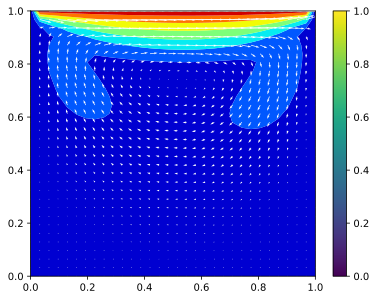

In [31]:
vel = np.sqrt(u**2 + v**2)
plt.contourf(xx, yy, vel, cmap='jet')
plt.quiver(xx, yy, u, v, color='w')
plt.colorbar()

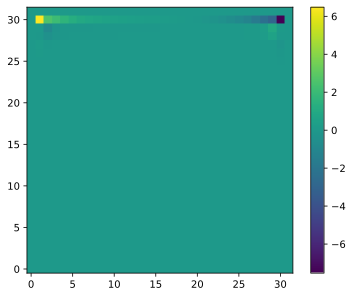

In [29]:
divu = div(u, v, dx, dy) 
plt.imshow(divu, origin='lower') 
plt.colorbar()